# Import packages

In [1]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import ot
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

from utils import *

In [2]:
import sys
sys.path.append("../")

from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty

In [3]:
import torch
from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load Shapes

In [12]:
posns = np.load("bone_star_data.npz")
labels = list(posns.keys())
posns = list(posns.values())

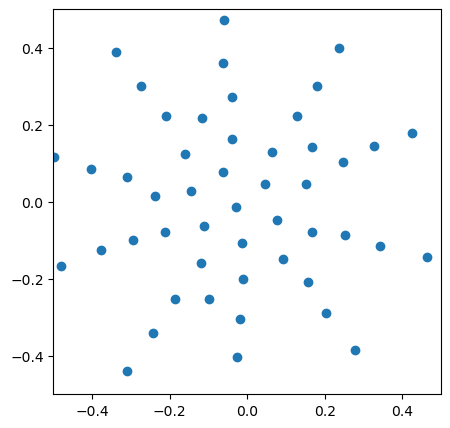

In [15]:
shape = posns[20]

plt.figure(figsize=(5,5))
plt.scatter(shape[:,0],shape[:,1])
plt.xlim(-.5, .5)
plt.ylim(-.5, .5)
plt.show()

In [16]:
numItem = 20
classes = np.arange(4)
N = len(classes)*20

In [17]:
Ms = []
LAMBDA_MAX = 0

for i in range(len(posns)):
    Ms.append(np.sqrt(cost_matrix_d(posns[i], posns[i])))
    LAMBDA_MAX = max(LAMBDA_MAX, Ms[i].max() ** 2)

# PGW

In [19]:
st = time.time()        
pgw = np.zeros((N,N))

for i in range(N):
    shape_i = posns[i]
    M1 = Ms[i]

    for j in range(i+1, N):
        shape_j = posns[j]
        M2 = Ms[j]

        alpha = 1/min(shape_i.shape[0], shape_j.shape[0])
        height1 = np.ones(shape_i.shape[0]) * alpha
        height2 = np.ones(shape_j.shape[0]) * alpha

        Lambda = LAMBDA_MAX
        
        gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=None, Lambda=Lambda, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)

        pgw_trans,pgw_penalty=PGW_dist_with_penalty(M1,M2,gamma, height1, height2, Lambda)
        pgw[i, j]=pgw_trans+pgw_penalty 

pgw[pgw < 0] = 0
pgw = np.sqrt(pgw)
pgw += pgw.T
et = time.time()
print("PGW computation: " + str(np.round(et-st,2)) + "s")

PGW computation: 5.8s


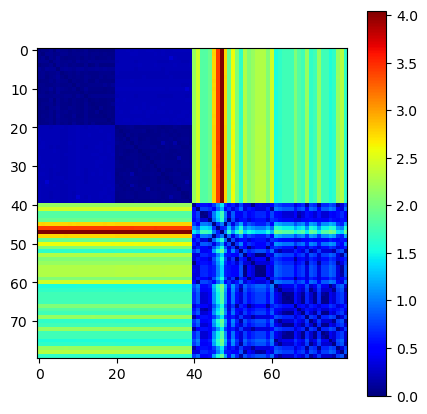

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(pgw, cmap='jet')
plt.colorbar()
plt.show()

# Mass Constrained PGW

In [21]:
N = 80

st = time.time()        
mpgw = np.zeros((N,N))

for i in range(N):
    shape_i = posns[i]
    M1 = Ms[i]

    for j in range(i+1, N):
        shape_j = posns[j]
        M2 = Ms[j]

        alpha = 1/min(shape_i.shape[0], shape_j.shape[0])
        height1 = np.ones(shape_i.shape[0]) * alpha
        height2 = np.ones(shape_j.shape[0]) * alpha

        mass = 1.0 - 1e-10
        gamma = partial_gromov_wasserstein(M1, M2, height1, height2, G0=None, m=mass, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        mpgw[i, j]=MPGW_dist(M1,M2,gamma)

mpgw[mpgw < 0] = 0
mpgw = np.sqrt(mpgw)
mpgw += mpgw.T
et = time.time()
print("MPGW computation: " + str(np.round(et-st,2)) + "s")

MPGW computation: 7.75s


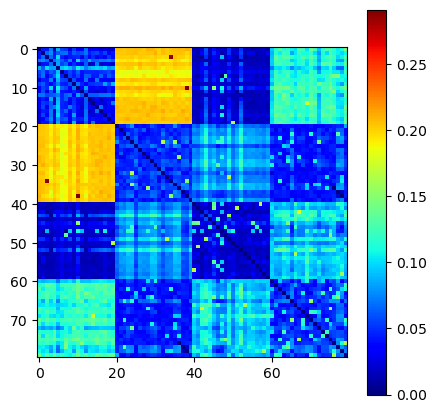

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(mpgw, cmap='jet')
plt.colorbar()
plt.show()

# Unbalanced GW

In [25]:
N = 80

st = time.time()        
ugw = np.zeros((N,N))

for i in tqdm(range(N)):
    shape_i = posns[i]
    M1 = Ms[i]
    M1 = torch.from_numpy(M1).to(device)

    for j in range(i+1, N):
        shape_j = posns[j]
        M2 = Ms[j]
        M2 = torch.from_numpy(M2).to(device)

        alpha = 1/min(shape_i.shape[0], shape_j.shape[0])
        height1 = np.ones(shape_i.shape[0]) * alpha
        height2 = np.ones(shape_j.shape[0]) * alpha

        height1 = torch.from_numpy(height1).to(device)
        height2 = torch.from_numpy(height2).to(device)

        eps = 1e-1
        rho = rho2 = 1

        pi, gamma = exp_ugw_sinkhorn(height1, M1, height2, M2, init=None, 
                                     eps=eps,
                                     rho=rho, 
                                     rho2=rho2,
                                     nits_plan=1000, tol_plan=1e-5, nits_sinkhorn=1000, 
                                     tol_sinkhorn=1e-5, two_outputs=True)
        
        # print(gamma.max())

        cost = ugw_cost(pi, gamma, height1, M1, height2, M2, eps=eps, rho=rho, rho2=rho2)
        ugw[i, j] = cost

ugw[ugw < 0] = 0
ugw = np.sqrt(ugw)
ugw += ugw.T
et = time.time()
print("ugw computation: " + str(np.round(et-st,2)) + "s")

  0%|          | 0/80 [00:00<?, ?it/s]

False
ugw computation: 74.95s


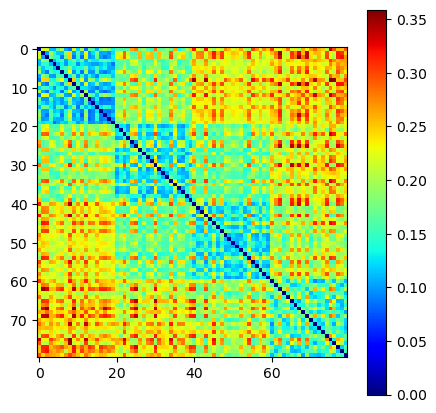

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(ugw, cmap='jet')
plt.colorbar()
plt.show()

# Plot

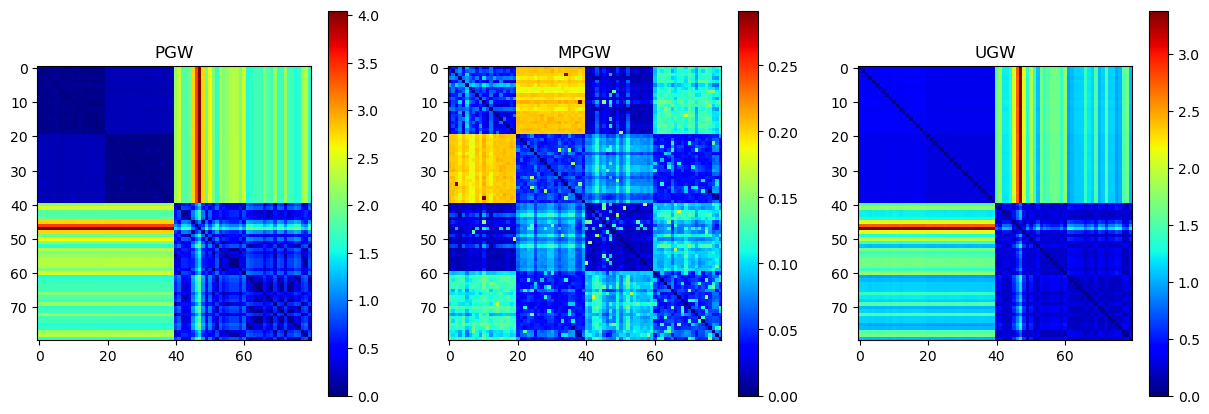

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

img = axs[0].imshow(pgw, cmap='jet')
fig.colorbar(img, ax=axs[0])
axs[0].set_title("PGW")
img = axs[1].imshow(mpgw, cmap='jet')
fig.colorbar(img, ax=axs[1])
axs[1].set_title("MPGW")
img = axs[2].imshow(ugw, cmap='jet')
fig.colorbar(img, ax=axs[2])
axs[2].set_title("UGW")

plt.show()

# Confusion Matrix

In [34]:
X = np.arange(N)                                           # dataset
y = np.concatenate([np.ones(numItem)*i for i in classes])  # labels

In [35]:
def conf_mat(dists, X, y, n_its = 10000):
    N = len(y)
    classes = np.array(np.unique(y),dtype=int)
    x_pred = []
    x_true = []
    for j in range(n_its):
        l = []
        for i in classes:
            l.append([np.random.choice(X[y == i]),i])
        l = np.array(l)
        for i in range(N):
            tmp1 = np.argmin(dists[i][l[:,0]])
            x_true.append(y[i])
            x_pred.append(tmp1)
    
    conf = sklearn.metrics.confusion_matrix(x_true, x_pred)
    return conf

def plot_conf(confs):
    fig = plt.figure(figsize=(len(confs) * 6, 6))
    min_val, max_val = 0, 1

    grid = ImageGrid(fig, 111,          
                     nrows_ncols=(1,len(confs)),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    
    animal_strings = ["bone","bone handle","star","star center"]
    x = [0,1,2,3]
    plt.setp(grid, xticks=x, xticklabels=animal_strings, yticks=x, yticklabels=animal_strings)
    
    for data, ax in zip(confs, grid):
        data = data/np.max(data)
        ax.xaxis.get_label().set_fontsize(20)
        ax.yaxis.get_label().set_fontsize(20)
        im = ax.imshow(data, vmin = min_val, vmax = max_val,cmap = "jet")
    
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    plt.show()

In [36]:
#compute confusion matrices
conf_pgw = conf_mat(pgw, X=X, y=y)
conf_mpgw = conf_mat(mpgw, X=X, y=y)
conf_ugw = conf_mat(ugw, X=X, y=y)

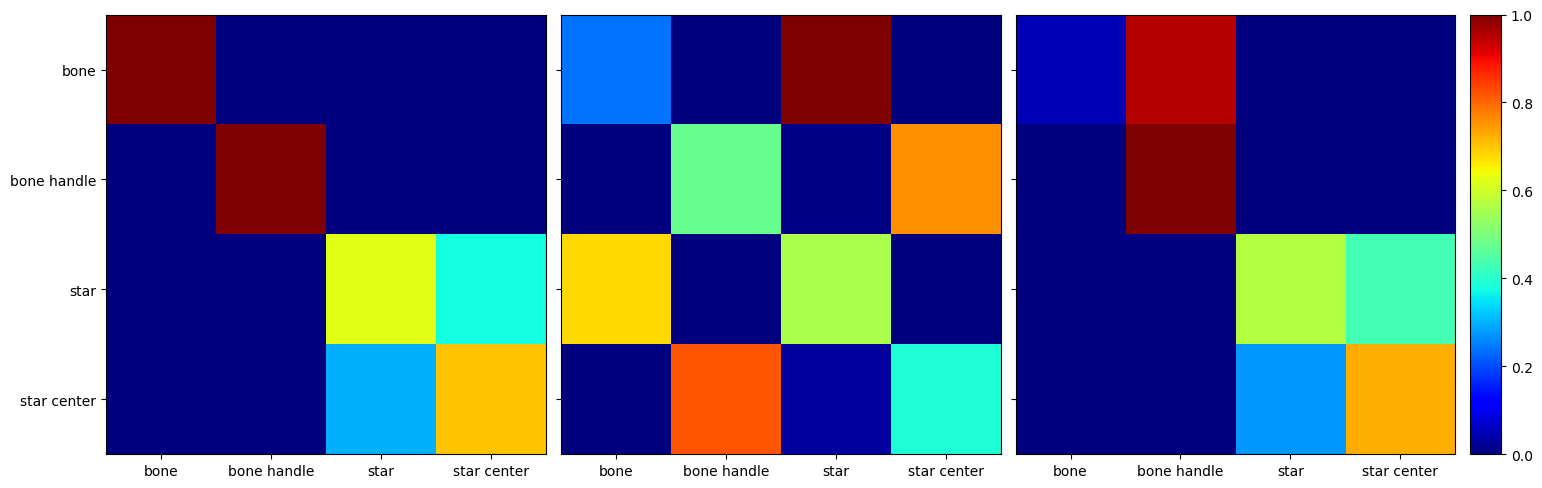

In [37]:
plot_conf([conf_pgw, conf_mpgw, conf_ugw])

# Perform 10-fold cross validation

In [38]:
def svm_cross_val(dist, gamma=10, k=10):
    k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
    k_folds.get_n_splits(X,y)

    accs = []

    for train_index, test_index in k_folds.split(X, y):
        
        # get train and test data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # set up SVM
        kernel_train = np.exp(-gamma * dist[X_train].T[X_train].T)
        svc = svm.SVC(kernel="precomputed")
        
        # fit SVM
        clf = svc.fit(kernel_train, y_train)

        kernel_test = np.exp(-gamma * dist[X_test].T[X_train].T)
        acc = clf.score(kernel_test, y_test)
        accs.append(acc)

    return accs, np.mean(accs)

In [39]:
accs_pgw, mean_acc_pgw = svm_cross_val(pgw)
print("Mean accuracy for PGW: ", mean_acc_pgw)

accs_mpgw, mean_acc_mpgw = svm_cross_val(mpgw)
print("Mean accuracy for MPGW: ", mean_acc_mpgw)

accs_ugw, mean_acc_ugw = svm_cross_val(ugw)
print("Mean accuracy for UGW: ", mean_acc_ugw)

Mean accuracy for PGW:  0.9125
Mean accuracy for MPGW:  0.15
Mean accuracy for UGW:  0.8625
